In [1]:
suppressWarnings({
    library(lmerTest)
    library(lme4)
    library(ggplot2)
    library(dplyr)
    library(tidyr)
    library(sjPlot)
    library(IRdisplay)
    library(car)
    library(ggeffects)
    library(gridExtra)
    library(repr)
    
})
options(repr.plot.width=4, repr.plot.height=3)

Loading required package: lme4
Loading required package: Matrix

Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack

Learn more about sjPlot with 'browseVignettes("sjPlot")'.
Loading required package: carData
Registered S3 methods overwritten by 'car':
  method                          from
  influence.merMod                lme4
  cooks.distance.influence.merMod lme4
  dfbeta.influence.merMod         lme4
  dfbetas.influence.merMod        lme4

Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode


Attaching package: ‘gridExtra’

The follow

# Investigating MHWs + Phytoplankton Performance Response via LMMs

Tony Cannistra, May 2020

**Purpose**: To experiment with linear mixed effects models to examine whether a significant relationship exists between latitude, yearly mean sea surface temperature, and performance ratio during marine heatwave events. 

**Method**: Build a linear mixed model of performance ratio with the following effects: 

*Fixed*: 
* Second-degree polynomial of Latitude *(perhaps also abs(lat))*
* mean_sst_event_year_local
* season
* *interaction terms*


*Random*:
* phytoplankton isolate


Perhaps season should be a fixed effect, especially since it likely does have control over the direction + shape of the curve. 

## Data

We compute individual isolate performance for all local heatwaves in [this notebook](../Individual_Isolate_performance.ipynb), and use these data below. 

In [2]:
mhwPerformance <- read.csv("../tmax_only_isolate_performance_withnegative.csv")
mhwPerformance = mhwPerformance %>% mutate(isolate = factor(isolate))
head(mhwPerformance)

X,lat,lon,isolate,mhw,detriment_sum,relative_detriment_mean,detriment_mean,performance_diff_mean,performance_diff_unscaled_mean,...,intensity_mean,duration,start_doy,peak_doy,current_year_sst_mean,start_date,peak_date,perf_det_ratio,latbin,doy_bins
0,-74.875,164.625,1,4,3.433027,1.303966,0.4291283,0.23719293,0.078058928,...,1.2978105,9,1,1,-1.202301,1986-12-31,5.364576e+17,0.8461350,"(-75.026, -59.75]","(0.639, 91.25]"
1,-74.875,164.625,1,5,6.265167,1.269172,0.4176778,0.28725032,0.094532547,...,1.5283193,16,21,32,-1.103370,1987-01-21,5.391360e+17,0.8156109,"(-75.026, -59.75]","(0.639, 91.25]"
2,-74.875,164.625,1,11,9.585366,1.713322,0.5638451,0.03568606,0.011744091,...,0.1877301,18,232,244,-1.168743,1988-08-19,5.889888e+17,0.9795979,"(-75.026, -59.75]","(181.5, 271.75]"
3,-74.875,164.625,1,14,10.139295,1.711648,0.5632942,0.03325621,0.010944441,...,0.1741022,19,196,201,-1.181397,1989-07-15,6.168960e+17,0.9809409,"(-75.026, -59.75]","(181.5, 271.75]"
4,-74.875,164.625,1,37,6.210158,1.715494,0.5645598,0.02973751,0.009786456,...,0.1560303,12,215,220,-1.219370,1995-08-03,8.078400e+17,0.9829606,"(-75.026, -59.75]","(181.5, 271.75]"
5,-74.875,164.625,1,69,5.665564,1.721560,0.5665564,0.02600654,0.008558612,...,0.1353238,11,133,138,-1.088333,2004-05-12,1.084752e+18,0.9851187,"(-75.026, -59.75]","(91.25, 181.5]"


We need to adjust for the effect of hemisphere to "align" seasons and convert to "season" factor variables from "peak_doy" column:

In [3]:
mhwPerformance[between(mhwPerformance$lat, -90, 0), 'peak_doy'] = (mhwPerformance[between(mhwPerformance$lat, -90, 0), 'peak_doy'] - 180) %% 365

In [4]:
mhwPerformance = mhwPerformance %>%  
                    mutate(season = 
                           case_when(
                                (between(peak_doy, 0, 77) | between(peak_doy, 355, 366)) ~ "winter", # January 1 - March XX or December XX - December 31
                                between(peak_doy, 78, 170) ~ "spring", # March XX - June XX
                                between(peak_doy, 171, 295) ~ "summer", # June XX - September XX
                                between(peak_doy, 296, 354) ~ "fall" # September XX - December XX
                        )
                    )

In [5]:
head(mhwPerformance %>% select(peak_doy, season))

peak_doy,season
186,summer
217,summer
64,winter
21,winter
40,winter
323,fall


We'll clean up by dropping NAs and `Inf`s 

We'll also **scale the input variables** for later, but the initial models will use the raw values: 

In [6]:
mhwPerformance = mhwPerformance %>%
    mutate(
        lat_scaled = scale(lat),
        sst_scaled = scale(current_year_sst_mean), 
        abslat_scaled = scale(abs(lat)),
        abslat = abs(lat)
    )

## Models

Let's define the standard model formulations here:

In [43]:
formula <- performance_diff_mean ~ (poly(lat_scaled, 2) + sst_scaled + season)^2
formula_unscaled <- performance_diff_mean ~ (poly(lat, 2) + current_year_sst_mean + season)^2

formula_abslat <- performance_diff_mean ~ (abslat_scaled + sst_scaled + season)^2
formula_abslat_unscaled <- performance_diff_mean ~ (abslat + current_year_sst_mean + season)^2

And the random effects formulations: 

In [44]:
formula_re <- performance_diff_mean ~ (poly(lat_scaled, 2) + sst_scaled + season)^2 + (1|isolate)
formula_unscaled_re <- performance_diff_mean ~ (poly(lat, 2) + current_year_sst_mean + season)^2 + (1|isolate)

formula_abslat_re <- performance_diff_mean ~ (abslat_scaled + sst_scaled + season)^2 + (1|isolate)
formula_abslat_unscaled_re <- performance_diff_mean ~ (abslat + current_year_sst_mean + season)^2 + (1|isolate)

We'll start with a simple linear model with all terms.

In [45]:
simple_lm = lm(formula, data=mhwPerformance)
summary(simple_lm)


Call:
lm(formula = formula, data = mhwPerformance)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.00063 -0.06463  0.00245  0.07225  1.09131 

Coefficients:
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                        0.072944   0.004506  16.190  < 2e-16 ***
poly(lat_scaled, 2)1               1.952431   0.475186   4.109 4.01e-05 ***
poly(lat_scaled, 2)2               0.448298   1.155152   0.388  0.69796    
sst_scaled                        -0.040738   0.012121  -3.361  0.00078 ***
seasonspring                       0.023129   0.005084   4.549 5.46e-06 ***
seasonsummer                      -0.103913   0.004768 -21.796  < 2e-16 ***
seasonwinter                       0.049981   0.005247   9.526  < 2e-16 ***
poly(lat_scaled, 2)1:sst_scaled    0.062740   0.165290   0.380  0.70427    
poly(lat_scaled, 2)2:sst_scaled    1.491282   0.182756   8.160 3.79e-16 ***
poly(lat_scaled, 2)1:seasonspring  0.016075   0.531682   0.030  0.975

In [46]:
baseline_hline = geom_hline(yintercept=0, linetype='dashed', color='blue', size=0.6, alpha=0.6)

## Simple Model with Random Effects

Only `isolate` as random effect for now: 

In [32]:
simple_re = lmer(
    formula_re,
    data=mhwPerformance
)
summary(simple_re)


Correlation matrix not shown by default, as p = 18 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: formula_re
   Data: mhwPerformance

REML criterion at convergence: -13262.2

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-16.2182  -0.3373  -0.0221   0.3875   7.0353 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept) 0.01048  0.1024  
 Residual             0.01295  0.1138  
Number of obs: 9170, groups:  isolate, 130

Fixed effects:
                                    Estimate Std. Error         df t value
(Intercept)                        6.515e-02  1.410e-02  1.305e+02   4.619
poly(lat_scaled, 2)1              -1.137e-01  1.582e+00  1.267e+02  -0.072
poly(lat_scaled, 2)2               1.411e+01  2.471e+00  3.412e+02   5.708
sst_scaled                         1.183e-01  2.016e-02  1.071e+03   5.868
seasonspring                       2.200e-02  3.971e-03  9.014e+03   5.540
seasonsummer                      -8.458e-02  3.733e-03  9.015e+03 -22.

Model contains splines or polynomial terms. Consider using `terms="lat_scaled [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.


Error: Confidence intervals could not be computed.
* Reason: "`season` does not have enough factor levels. Try to remove `[]`."
* Source: .safe_se_from_vcov(model, prediction_data, value_adjustment, terms, model_class, type, vcov.fun, vcov.type, vcov.args, condition, interval)


Model contains splines or polynomial terms. Consider using `terms="sst_scaled [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.


Error: Confidence intervals could not be computed.
* Reason: "`season` does not have enough factor levels. Try to remove `[]`."
* Source: .safe_se_from_vcov(model, prediction_data, value_adjustment, terms, model_class, type, vcov.fun, vcov.type, vcov.args, condition, interval)


Model contains splines or polynomial terms. Consider using `terms="season [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.


NULL

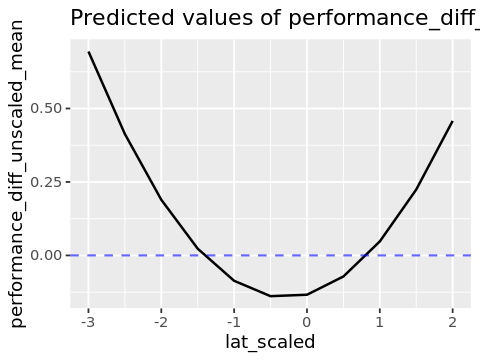

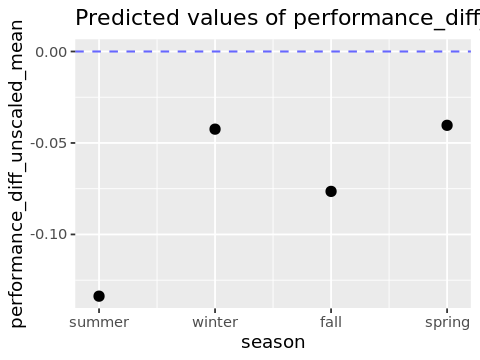

In [33]:
simple_re_plots = plot_model(simple_re, type='pred')
simple_re_plots$lat + baseline_hline
simple_re_plots$current_year_sst_mean + baseline_hline
simple_re_plots$season + baseline_hline

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Warning message:
“Removed 9 rows containing missing values (geom_point).”

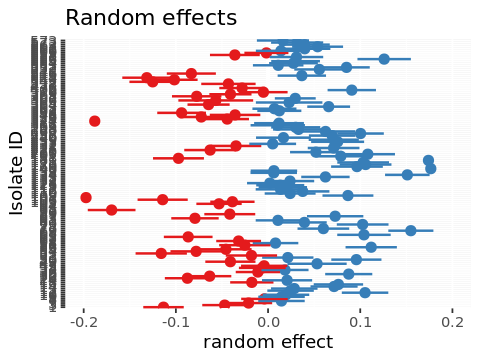

In [34]:
plot_model(simple_re, type='re') +
    xlab("Isolate ID") + 
    ylab('random effect')+
    ylim(-0.2, 0.2)

## More Intense Heatwaves =? Stronger Signal?

There's probably a lot of noise from shorter events here. 

Lets take a look at the distribution of heatwaves by intensity: 

In [35]:
median(mhwPerformance$intensity_mean)

[1] 1.496034

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


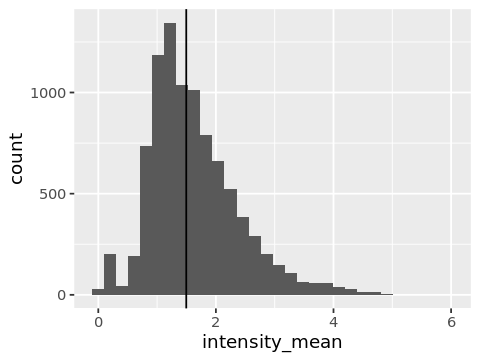

In [36]:
ggplot(mhwPerformance, aes(x=intensity_mean)) +
    geom_histogram() + 
    geom_vline(xintercept=median(mhwPerformance$intensity_mean)) 

We can use ~1.5 C as our threshold (median?)

In [37]:
intensity_threshold = 1.5

In [38]:
intenseMhwPerformance = mhwPerformance %>% filter(intensity_mean > intensity_threshold)

In [39]:
head(intenseMhwPerformance)

X,lat,lon,isolate,mhw,detriment_sum,relative_detriment_mean,detriment_mean,performance_diff_mean,performance_diff_unscaled_mean,...,start_date,peak_date,perf_det_ratio,latbin,doy_bins,season,lat_scaled,sst_scaled,abslat_scaled,abslat
1,-74.875,164.625,1,5,6.265167e+00,1.2691721152,0.4176777708,0.28725032,0.09453255,...,1987-01-21,5.391360e+17,8.156109e-01,"(-75.026, -59.75]","(0.639, 91.25]",summer,-2.512773,-2.1110269,2.1837887,74.875
16,-57.875,62.125,8,37,5.392747e-04,0.0003390271,0.0001078549,0.07245527,0.02305025,...,2000-01-10,9.475488e+17,4.609214e-03,"(-59.75, -44.625]","(0.639, 91.25]",summer,-2.045108,-1.9549025,1.2378394,57.875
39,-57.875,139.875,558,6,8.048469e-01,0.1441267048,0.0473439352,-0.14278485,-0.04690315,...,1985-01-03,4.737312e+17,3.234330e+04,"(-59.75, -44.625]","(0.639, 91.25]",summer,-2.045108,-1.7193377,1.2378394,57.875
48,-46.625,-75.875,476,23,7.949109e-02,0.0356370802,0.0066242573,0.04883279,0.00907709,...,1992-01-26,6.971616e+17,4.533501e-01,"(-59.75, -44.625]","(0.639, 91.25]",summer,-1.735625,-0.7799926,0.6118436,46.625
52,-42.125,169.625,15,58,1.297108e+01,0.1026763952,0.1457425124,0.10700543,0.15188730,...,2016-02-24,1.459382e+18,4.387885e-01,"(-44.625, -29.5]","(0.639, 91.25]",summer,-1.611831,-0.1946099,0.3614453,42.125
53,-42.125,169.625,15,67,2.416684e+00,0.3405134209,0.4833368116,0.11409630,0.16195234,...,2018-10-19,1.540253e+18,7.483851e-01,"(-44.625, -29.5]","(271.75, 362.0]",spring,-1.611831,-0.1955015,0.3614453,42.125


In [19]:
nrow(intenseMhwPerformance)

[1] 4570

**Simple Model**

In [20]:
simple_intense_lm = lm(
    formula,
    data=intenseMhwPerformance)
summary(simple_intense_lm)


Call:
lm(formula = formula, data = intenseMhwPerformance)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.92402 -0.06593  0.00956  0.07719  1.00890 

Coefficients:
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                        0.111464   0.007439  14.985  < 2e-16 ***
poly(lat_scaled, 2)1               2.580157   0.603783   4.273 1.97e-05 ***
poly(lat_scaled, 2)2               1.028692   0.878472   1.171 0.241659    
sst_scaled                         0.010018   0.020025   0.500 0.616911    
seasonspring                       0.006093   0.008631   0.706 0.480249    
seasonsummer                      -0.168070   0.008106 -20.733  < 2e-16 ***
seasonwinter                       0.055973   0.009301   6.018 1.91e-09 ***
poly(lat_scaled, 2)1:sst_scaled    1.235104   0.226532   5.452 5.24e-08 ***
poly(lat_scaled, 2)2:sst_scaled    0.851864   0.209612   4.064 4.91e-05 ***
poly(lat_scaled, 2)1:seasonspring -1.510926   0.727712  -2.076

**Simple Random Effects**

In [21]:
simple_intense_re = lmer(
    formula_re, 
    data=intenseMhwPerformance
)
summary(simple_intense_re)


Correlation matrix not shown by default, as p = 18 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: formula_re
   Data: intenseMhwPerformance

REML criterion at convergence: -6131.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.2333 -0.4729  0.0280  0.5208  4.8315 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept) 0.01625  0.1275  
 Residual             0.01389  0.1179  
Number of obs: 4570, groups:  isolate, 122

Fixed effects:
                                    Estimate Std. Error         df t value
(Intercept)                        1.099e-01  1.626e-02  1.179e+02   6.759
poly(lat_scaled, 2)1               5.858e+00  9.432e-01  2.343e+02   6.210
poly(lat_scaled, 2)2               8.638e+00  1.377e+00  3.308e+02   6.271
sst_scaled                         1.907e-01  2.616e-02  1.556e+03   7.288
seasonspring                       9.492e-03  6.411e-03  4.459e+03   1.481
seasonsummer                      -1.659e-01  6.037e-03  4.459e+03 -27.486


## Absolute Latitude instead of Poly(2)

In [23]:
abslat_re = lmer(
    formula_abslat_re, 
    data=mhwPerformance
)
summary(abslat_re)


Correlation matrix not shown by default, as p = 13 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: formula_abslat_re
   Data: mhwPerformance

REML criterion at convergence: -15685.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.8249 -0.4591 -0.0125  0.5156  6.2158 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept) 0.016669 0.12911 
 Residual             0.009784 0.09891 
Number of obs: 9170, groups:  isolate, 130

Fixed effects:
                             Estimate Std. Error         df t value Pr(>|t|)
(Intercept)                 4.633e-02  1.487e-02  1.329e+02   3.114  0.00226
abslat_scaled               2.155e-01  1.933e-02  4.337e+02  11.146  < 2e-16
sst_scaled                  2.029e-01  1.746e-02  2.139e+03  11.620  < 2e-16
seasonspring                2.038e-02  3.437e-03  9.014e+03   5.930 3.13e-09
seasonsummer               -9.880e-02  3.230e-03  9.015e+03 -30.589  < 2e-16
seasonwinter                4.768e-02  3.538e-03  9.011e+03  1

In [24]:
abslat_intense_re = lmer(
   formula_abslat_re,
    data=intenseMhwPerformance, 
)
summary(abslat_intense_re)


Correlation matrix not shown by default, as p = 13 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: formula_abslat_re
   Data: intenseMhwPerformance

REML criterion at convergence: -6233.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.3330 -0.4802  0.0505  0.5342  4.7829 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept) 0.01720  0.1311  
 Residual             0.01342  0.1158  
Number of obs: 4570, groups:  isolate, 122

Fixed effects:
                             Estimate Std. Error         df t value Pr(>|t|)
(Intercept)                 8.096e-02  1.651e-02  1.233e+02   4.904 2.90e-06
abslat_scaled               2.134e-01  2.512e-02  4.644e+02   8.494 2.73e-16
sst_scaled                  1.962e-01  2.507e-02  1.429e+03   7.827 9.64e-15
seasonspring                9.800e-03  6.513e-03  4.477e+03   1.505 0.132456
seasonsummer               -1.474e-01  6.120e-03  4.479e+03 -24.082  < 2e-16
seasonwinter                6.315e-02  6.944e-03  4.472e

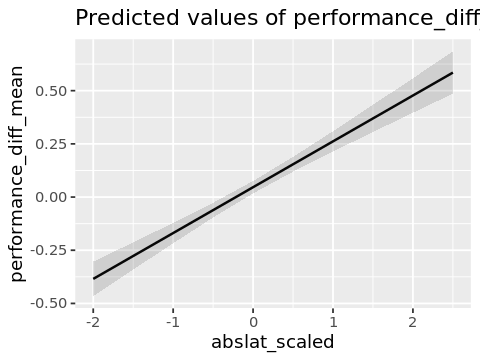

$abslat_scaled

$sst_scaled

$season


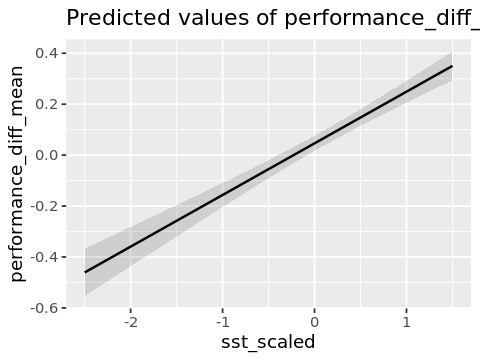

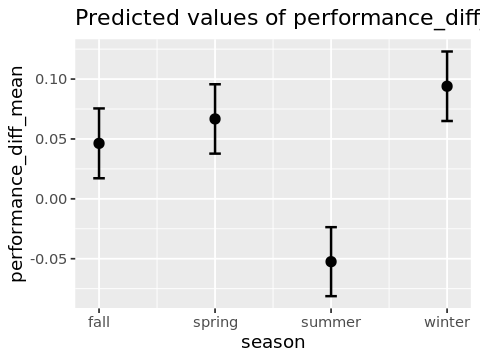

In [25]:
plot_model(abslat_re, type='pred')

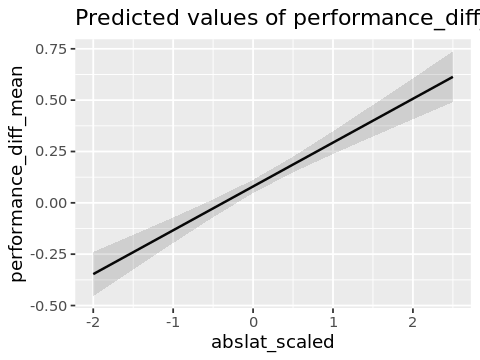

$abslat_scaled

$sst_scaled

$season


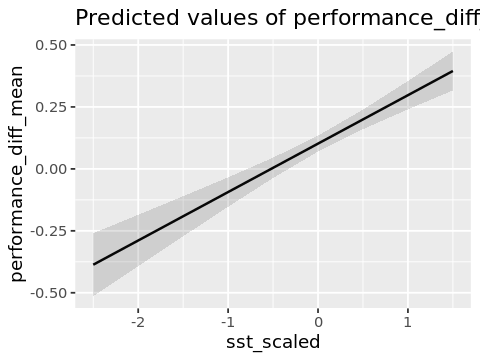

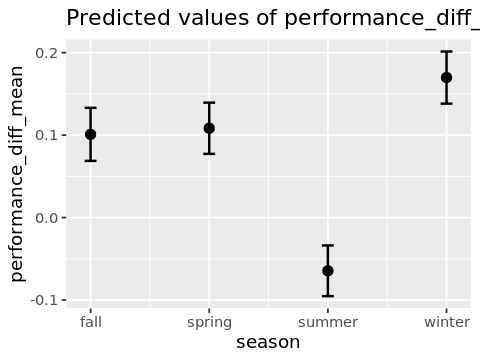

In [26]:
plot_model(abslat_intense_re, type='pred')

## Produce Plots

### Absolute Latitude

**Coefficient Plots, Simple and Intense**

In [27]:
png("./tmax_only_abslat_compare_coefs_diff.png", width=1440, height=950, res=180)
y_limit = ylim(-1, 1)
simple_coefs = plot_model(abslat_re, ci.lvl=NA,  show.values = TRUE, value.offset=.4) + y_limit + ggtitle("A) All MHWs")
intense_coefs = plot_model(abslat_intense_re,show.values = TRUE, value.offset=.4, ci.lvl=NA)+ y_limit + theme(axis.text.y = element_blank()) + ggtitle("B) Intense MHWs")
grid.arrange(simple_coefs, intense_coefs, nrow=1, widths=c(1.7, 1) )
dev.off()

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


png 
  2

**Coefficient Table**

In [28]:
tab_model(
    abslat_re, abslat_intense_re,
    show.stat=TRUE, use.viewer=FALSE, 
    dv.labels=c("Performance Difference [all events]", "Performance Difference [intense events]"), 
    file = "tmax_only_abslat_coef_compare_table.html"
)

**Predictions, All MHW**

In [29]:
png("./tmax_only_abslat_preds_preddiff.png", width=1440, height=700, res=180)

y_limit = ylim(-1, 1)

seas = plot(ggeffect(abslat_re, terms='season')) +
    baseline_hline + 
    xlab("Season") +
    ylab("Performance Difference")  +
    ggtitle("A) Season") + 
    y_limit


seaslat = plot(ggeffect(abslat_re, terms=c('abslat_scaled', 'season [summer, winter]'))) +
    baseline_hline +
    xlab("Absolute Latitude [scaled]") +
    ylab("Performance Difference")  +
    ggtitle("B) Latitude") + 
    y_limit

    

grid.arrange(seas, seaslat, nrow=1, widths=c(1,1.3))
dev.off()
# seaslat

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


png 
  2

**Predictions, Intense MHW**

In [31]:
png("./tmax_only_abslat_preds_intense_preddiff.png", width=1440, height=700, res=180)

y_limit = ylim(-1, 1)

seas = plot(ggeffect(abslat_intense_re, terms='season')) + 
    baseline_hline + 
    xlab("Season") +
    ylab("Performance Difference")  +
    ggtitle("A) Season") + 
    y_limit 


seaslat = plot(ggeffect(abslat_intense_re, terms=c('abslat_scaled', 'season [summer, winter]'))) +
    baseline_hline +
    xlab("Absolute Latitude [scaled]") +
    ylab("Performance Difference")  +
    ggtitle("B) Latitude") + 
    y_limit 

    

grid.arrange(seas, seaslat, nrow=1, widths=c(1,1.3))
# dev.off()
# seaslat

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


### Regular Latitude

**Coefficients**

In [32]:
png("./tmax_only_polylat_compare_coefs_diff.png", width=1440, height=950, res=180)
y_limit = ylim(-5.5,5.5)
simple_coefs = plot_model(simple_re, ci.lvl=NA,  show.values = TRUE, value.offset=.4) + y_limit + ggtitle("A) All MHWs")
intense_coefs = plot_model(simple_intense_re,show.values = TRUE, value.offset=.4, ci.lvl=NA)+ y_limit + theme(axis.text.y = element_blank()) + ggtitle("B) Intense MHWs")
grid.arrange(simple_coefs, intense_coefs, nrow=1, widths=c(2, 1) )
dev.off()

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_text).”Warning message:
“Removed 2 rows containing missing values (geom_point).”Warning message:
“Removed 2 rows containing missing values (geom_text).”

png 
  2

**Coefficients Table**

In [33]:
tab_model(
    simple_re, simple_intense_re,
    show.stat=TRUE, use.viewer=FALSE, 
    dv.labels=c("Performance Difference [all events]", "Performance Difference [intense events]"), 
    file = "tmax_only_polylat_coef_compare_table.html"
)

**Predictions, all MHW**

In [34]:
png("./tmax_only_polylat_preds_preddiff.png", width=1440, height=700, res=180)

 y_limit = ylim(-1, 1)

seas = plot(ggeffect(simple_re, terms='season')) + 
    baseline_hline + 
    xlab("Season") +
    ylab("Performance Difference")  +
    ggtitle("A) Season") + 
    y_limit


seaslat = plot(ggeffect(simple_re, terms=c('lat_scaled', 'season [summer, winter]'))) +
    baseline_hline +
    xlab("Latitude [scaled]") +
    ylab("Performance Difference")  +
    ggtitle("B) Latitude") + 
    y_limit
    

grid.arrange(seas, seaslat, nrow=1, widths=c(1,1.3))
dev.off()
# seaslat

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Warning message:
“Removed 2 row(s) containing missing values (geom_path).”

png 
  2

**Predictions, Intense MHW**

In [35]:
png("./tmax_only_polylat_preds_intense_preddiff.png", width=1440, height=700, res=180)

seas = plot(ggeffect(simple_intense_re, terms='season')) + 
    baseline_hline + 
    xlab("Season") +
    ylab("Performance Difference")  +
    ggtitle("A) Season") + 
    ylim(-0.5, 0.5) 



seaslat = plot(ggeffect(simple_intense_re, terms=c('lat_scaled', 'season [summer, winter]'))) +
    baseline_hline +
    xlab("Latitude [scaled]") +
    ylab("Performance Difference")  +
    ggtitle("B) Latitude") + 
    ylim(-0.5, 0.5) 

    

grid.arrange(seas, seaslat, nrow=1, widths=c(1,1.3)) 
dev.off()
# seaslat

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Warning message:
“Removed 5 row(s) containing missing values (geom_path).”

png 
  2

## Individual Models per Season

In [497]:
winter_only = mhwPerformance %>% filter(season == "winter")
winter_re = lmer(performance_diff_mean ~ (abslat + sst_scaled)^2 + (1 | isolate), data=winter_only, )

In [498]:
summary(winter_re)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: performance_diff_mean ~ (abslat + sst_scaled)^2 + (1 | isolate)
   Data: winter_only

REML criterion at convergence: -3908.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.8243 -0.3722  0.0080  0.3138  5.2430 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept) 0.021913 0.14803 
 Residual             0.001287 0.03588 
Number of obs: 1141, groups:  isolate, 75

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)       -8.181e-04  4.816e-02  1.777e+02  -0.017 0.986466    
abslat             5.187e-03  1.407e-03  1.697e+02   3.687 0.000306 ***
sst_scaled        -4.865e-02  3.358e-02  3.815e+02  -1.449 0.148191    
abslat:sst_scaled  2.736e-03  7.421e-04  1.272e+02   3.687 0.000335 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) abslat

In [499]:
summer_only = mhwPerformance %>% filter(season == "summer")
summer_re = lmer(performance_diff_mean ~ (abslat + sst_scaled)^2 + (1 | isolate), data=summer_only, )
summary(summer_re)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: performance_diff_mean ~ (abslat + sst_scaled)^2 + (1 | isolate)
   Data: summer_only

REML criterion at convergence: -4375.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.0612 -0.3711 -0.0288  0.3465  6.4595 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept) 0.032416 0.18004 
 Residual             0.005367 0.07326 
Number of obs: 2003, groups:  isolate, 75

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)   
(Intercept)       -1.818e-01  5.825e-02  1.716e+02  -3.121  0.00212 **
abslat             3.439e-03  1.692e-03  1.675e+02   2.033  0.04362 * 
sst_scaled         1.080e-01  4.239e-02  2.940e+02   2.548  0.01133 * 
abslat:sst_scaled -2.160e-03  9.399e-04  1.075e+02  -2.298  0.02349 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) abslat sst_

In [500]:
spring_only = mhwPerformance %>% filter(season == "spring")
spring_re = lmer(performance_diff_mean ~ (abslat + sst_scaled)^2 + (1 | isolate), data=spring_only, )
summary(spring_re)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: performance_diff_mean ~ (abslat + sst_scaled)^2 + (1 | isolate)
   Data: spring_only

REML criterion at convergence: -2613.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.3284 -0.2555  0.0049  0.2718  6.8615 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept) 0.018823 0.1372  
 Residual             0.006773 0.0823  
Number of obs: 1363, groups:  isolate, 75

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)       -2.208e-02  6.034e-02  1.766e+02  -0.366   0.7149  
abslat             3.918e-03  1.734e-03  1.652e+02   2.259   0.0252 *
sst_scaled        -1.478e-02  4.590e-02  2.218e+02  -0.322   0.7478  
abslat:sst_scaled  1.244e-03  7.886e-04  9.408e+01   1.577   0.1182  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) abslat sst_sc
ab

In [501]:
fall_only = mhwPerformance %>% filter(season == "fall")
fall_re = lmer(performance_diff_mean ~ (abslat + sst_scaled)^2 + (1 | isolate), data=fall_only, )
summary(fall_re)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: performance_diff_mean ~ (abslat + sst_scaled)^2 + (1 | isolate)
   Data: fall_only

REML criterion at convergence: -2220.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.8919 -0.3296  0.0008  0.3554  5.4018 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept) 0.016241 0.12744 
 Residual             0.002272 0.04767 
Number of obs: 792, groups:  isolate, 75

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)       -2.539e-02  5.468e-02  1.862e+02  -0.464   0.6430  
abslat             3.258e-03  1.577e-03  1.740e+02   2.066   0.0403 *
sst_scaled        -2.935e-02  4.141e-02  2.373e+02  -0.709   0.4792  
abslat:sst_scaled  1.216e-03  7.236e-04  9.740e+01   1.680   0.0962 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) abslat sst_sc
absla

In [502]:
tab_model(
    winter_re,
    spring_re,
    summer_re,
    fall_re,  
    show.stat=TRUE,
    use.viewer=FALSE, 
    dv.labels=c("Winter Only", "Spring Only", "Summer Only", "Autumn Only"), 
    file = "compare_season_models.html"
)

In [2]:
theme_black = function(base_size = 12, base_family = "") {
 
  theme_grey(base_size = base_size, base_family = base_family) %+replace%
 
    theme(
      # Specify axis options
      axis.line = element_blank(),  
      axis.text.x = element_text(size = base_size*0.8, color = "white", lineheight = 0.9),  
      axis.text.y = element_text(size = base_size*0.8, color = "white", lineheight = 0.9),  
      axis.ticks = element_line(color = "white", size  =  0.2),  
      axis.title.x = element_text(size = base_size, color = "white", margin = margin(0, 10, 0, 0)),  
      axis.title.y = element_text(size = base_size, color = "white", angle = 90, margin = margin(0, 10, 0, 0)),  
      axis.ticks.length = unit(0.3, "lines"),   
      # Specify legend options
      legend.background = element_rect(color = NA, fill = "black"),  
      legend.key = element_rect(color = "white",  fill = "black"),  
      legend.key.size = unit(1.2, "lines"),  
      legend.key.height = NULL,  
      legend.key.width = NULL,      
      legend.text = element_text(size = base_size*0.8, color = "white"),  
      legend.title = element_text(size = base_size*0.8, face = "bold", hjust = 0, color = "white"),  
      legend.position = "right",  
      legend.text.align = NULL,  
      legend.title.align = NULL,  
      legend.direction = "vertical",  
      legend.box = NULL, 
      # Specify panel options
      panel.background = element_rect(fill = "black", color  =  NA),  
      panel.border = element_rect(fill = NA, color = "white"),  
      panel.grid.major = element_line(color = "grey35"),  
      panel.grid.minor = element_line(color = "grey20"),  
      panel.margin = unit(0.5, "lines"),   
      # Specify facetting options
      strip.background = element_rect(fill = "grey30", color = "grey10"),  
      strip.text.x = element_text(size = base_size*0.8, color = "white"),  
      strip.text.y = element_text(size = base_size*0.8, color = "white",angle = -90),  
      # Specify plot options
      plot.background = element_rect(color = "black", fill = "black"),  
      plot.title = element_text(size = base_size*1.2, color = "white"),  
      plot.margin = unit(rep(1, 4), "lines")
 
    )
 
}
 